In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

In [139]:
site_key = 'Central'
freq_key = 'hf_'

In [140]:
bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

In [141]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000

In [142]:
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


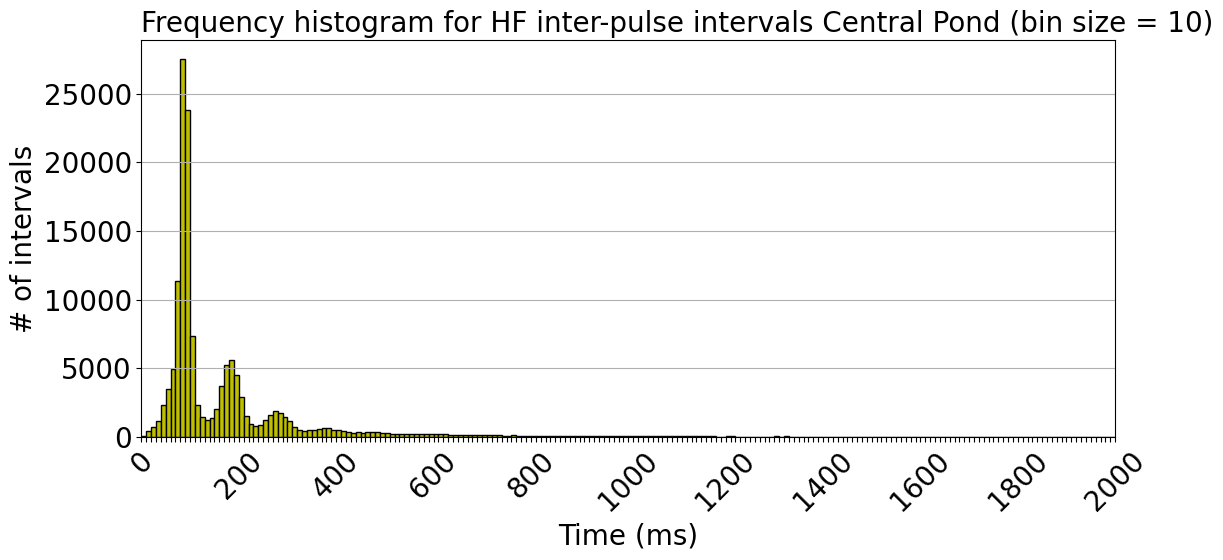

In [143]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(bout_params, fig_details)

In [144]:
ipis_loc, hist_loc = bt_clustering.get_histogram(bout_params, fig_details)
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)

fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)

slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = bt_clustering.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 694758023 missassigned points
Slater method has 1198602 missassigned points
Sibly method has 1169101 missassigned points
Optim BCI has less misassignments than BCI? True
29501 more points assigned correctly


In [145]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.005392686210999614, intercept=11.971445497369157, rvalue=-0.9759403420973916, pvalue=2.072084865589007e-27, stderr=0.00019292175953593456, intercept_stderr=0.04483096570822239),
  'indices': range(0, 41),
  'lambda': 0.005392686210999614,
  'num_intervals_slater': 29331047.253204886},
 {'metrics': LinregressResult(slope=-1.5550430020357336e-06, intercept=6.985066815936097, rvalue=-0.9944673599978867, pvalue=0.0, stderr=5.890857956467886e-10, intercept_stderr=0.0010477477034823227),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 1.5550430020357336e-06,
  'num_intervals_slater': 694758023.0348736})

In [146]:
nlin_results

{'solution': array([2.86650018e+07, 5.53110938e-03, 6.94764688e+08, 1.55505135e-06]),
 'fast_num_intervals': 28665001.75089571,
 'fast_lambda': 0.00553110938022405,
 'slow_num_intervals': 694764688.3012569,
 'slow_lambda': 1.5550513452015633e-06,
 'bci': 902.195464881716}

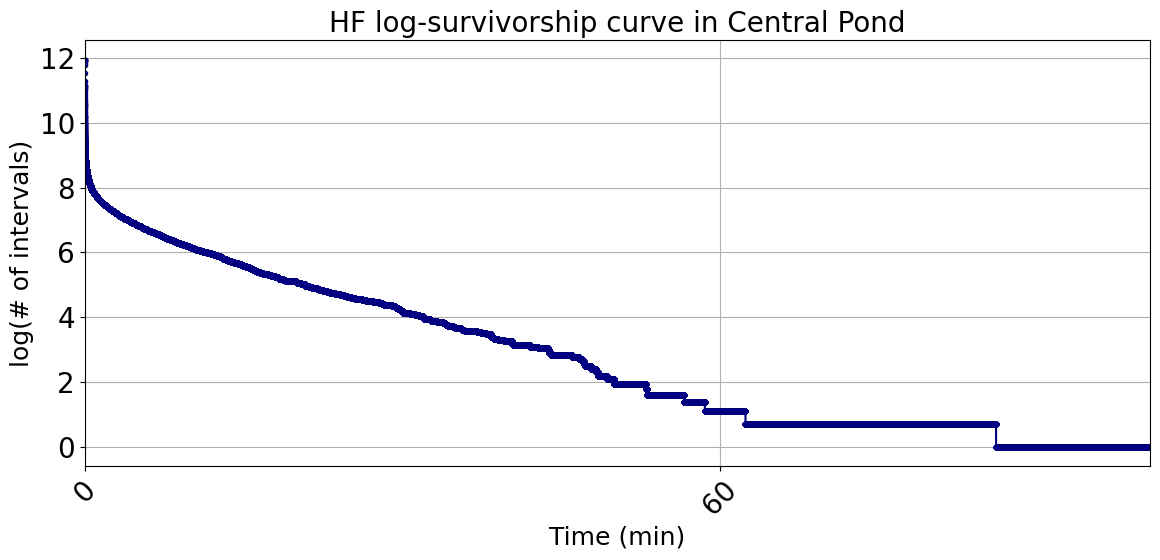

In [147]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

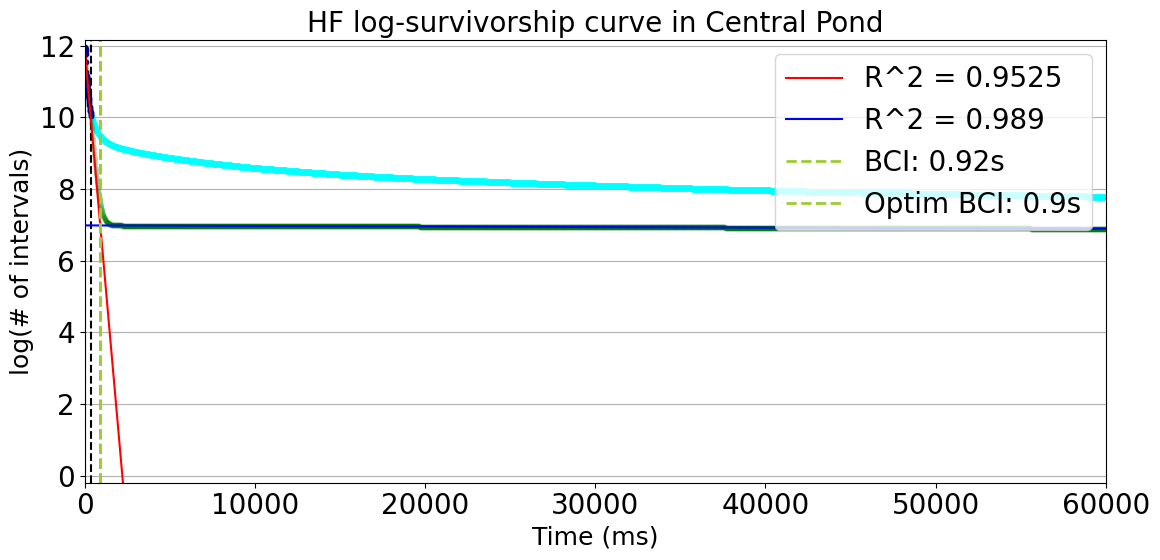

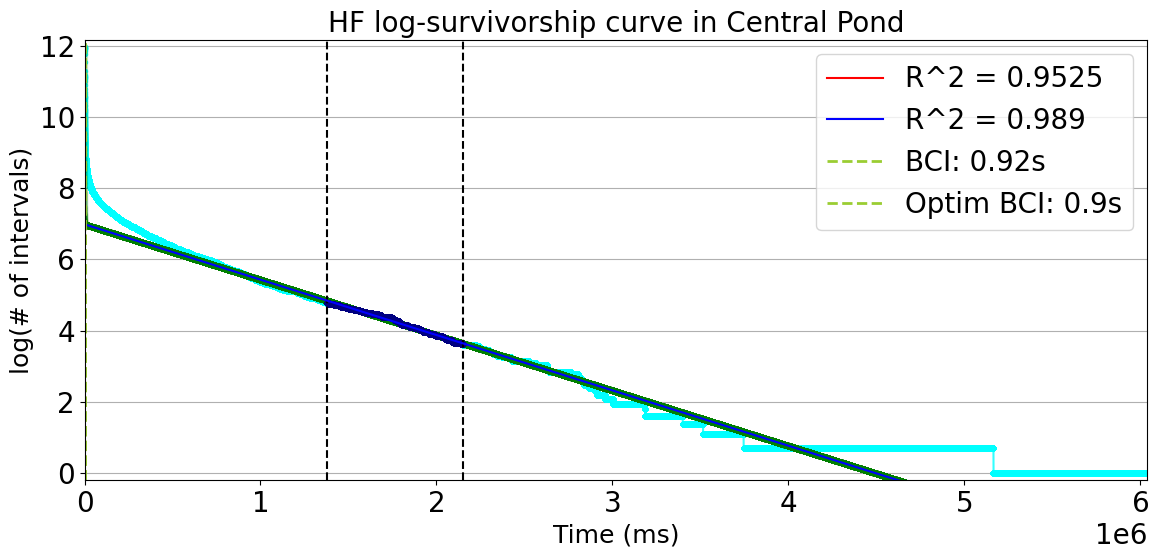

In [148]:
fig_details['time_end'] = 60000
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [149]:
filename = '20220826_043000'
file_path = Path(f'../../Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010/{filename}.WAV')
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

bout_params['bci'] = nlin_results['bci']

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/Central/bd2__Central_{filename}.csv')
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_single_bd2_output(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt_clustering.construct_bout_metrics_from_classified_dets(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

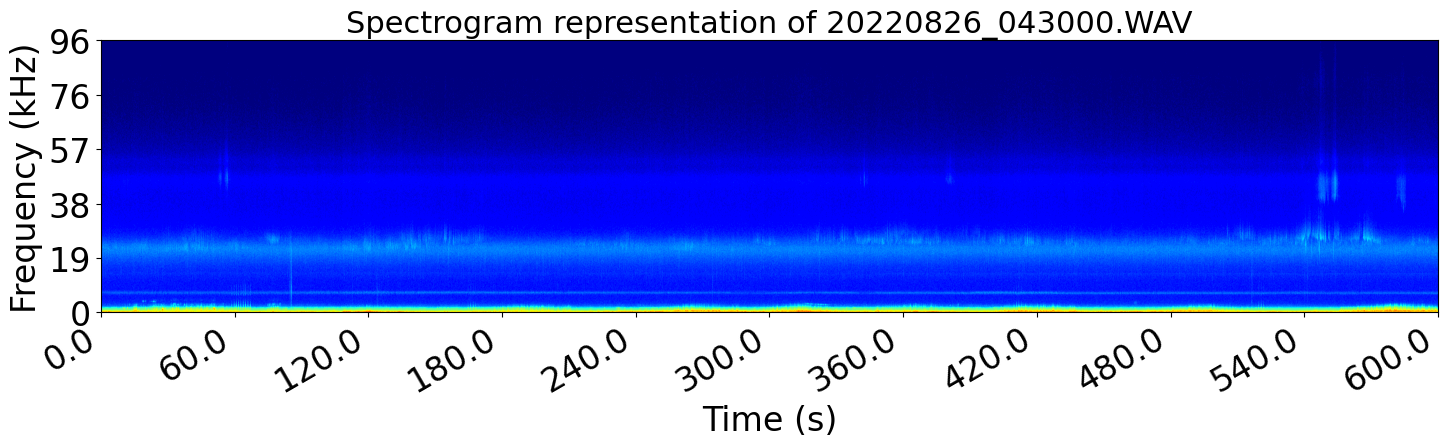

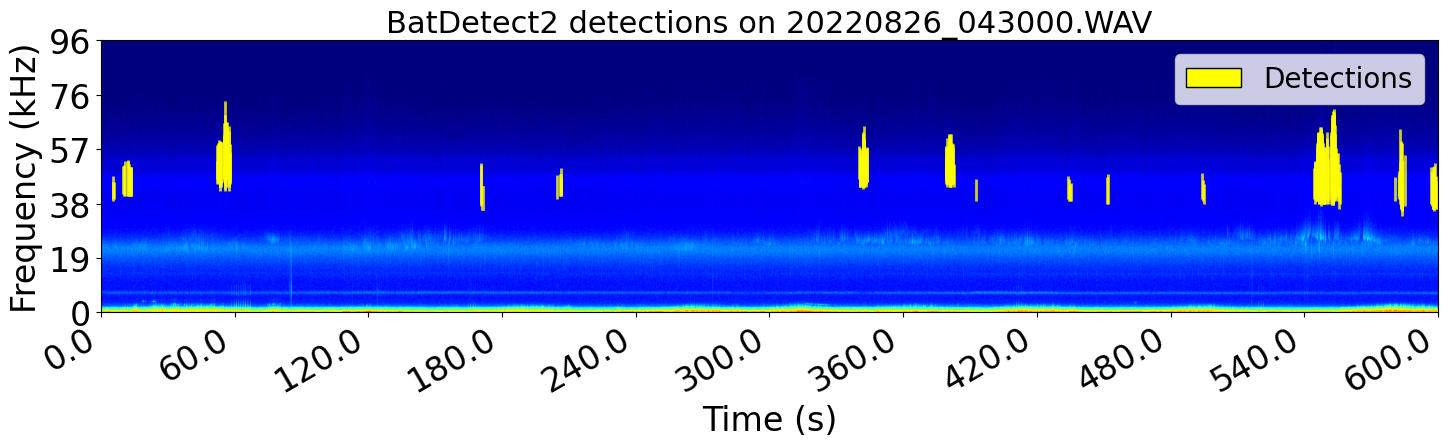

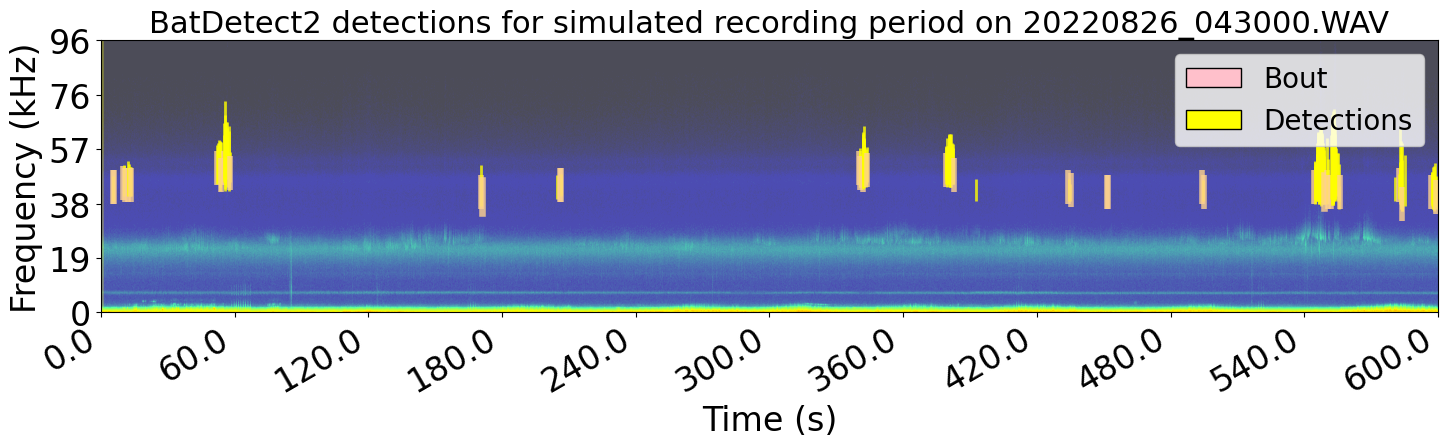

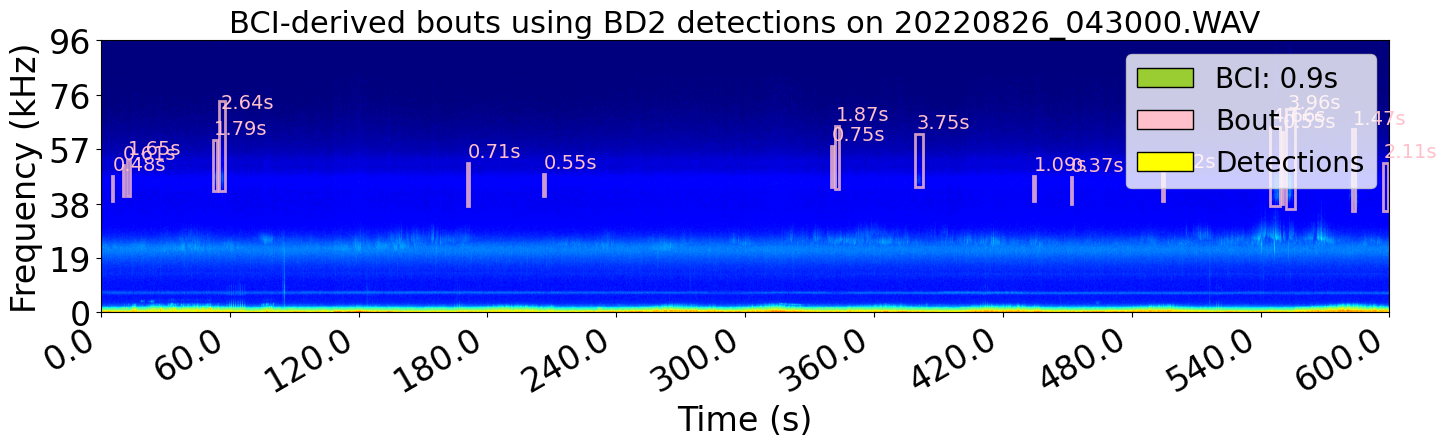

In [116]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [128]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

bout_params['bci'] = nlin_results['bci']

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

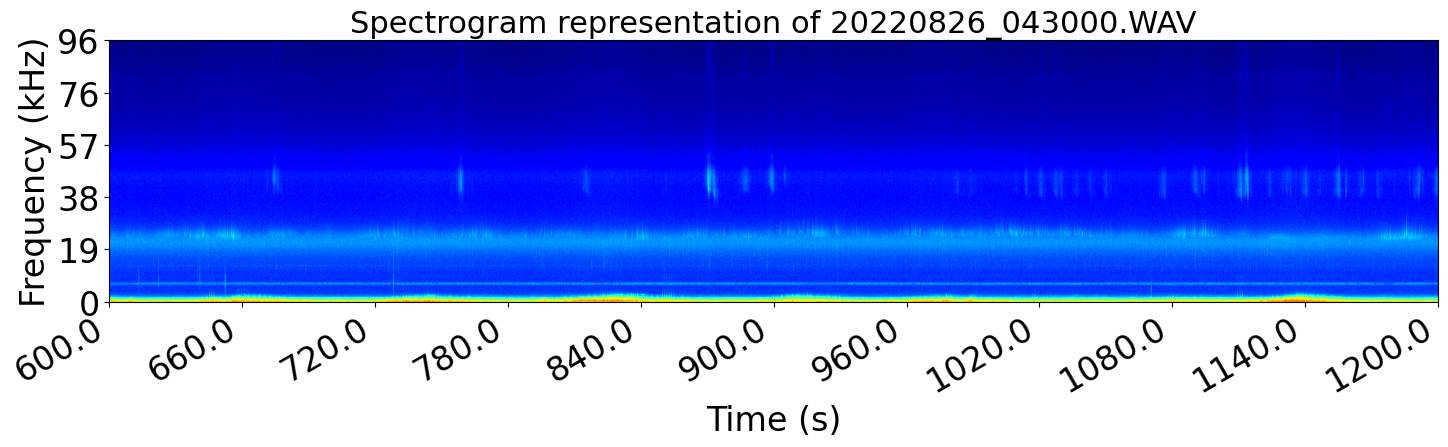

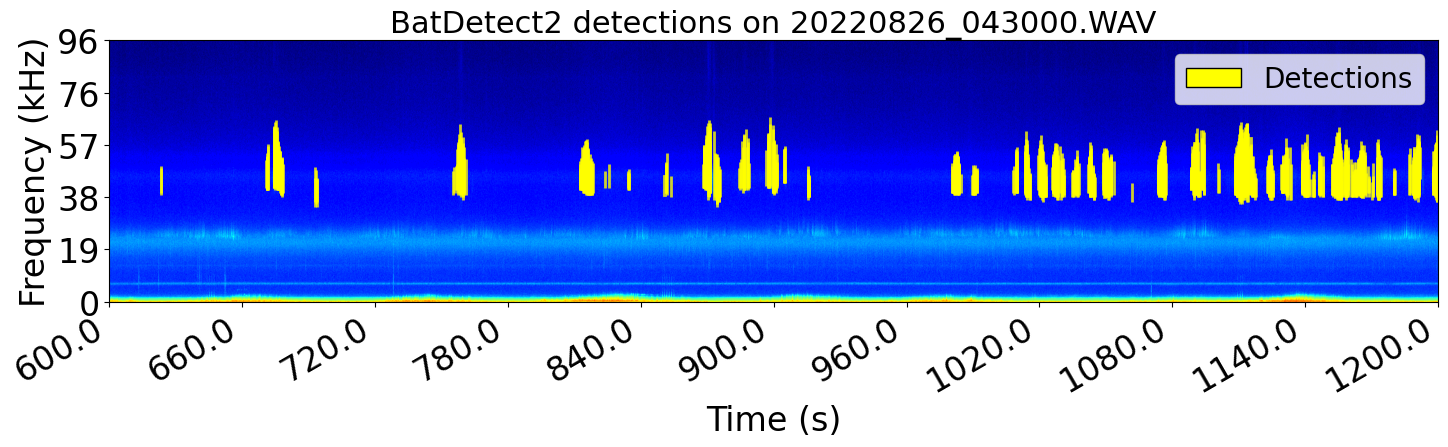

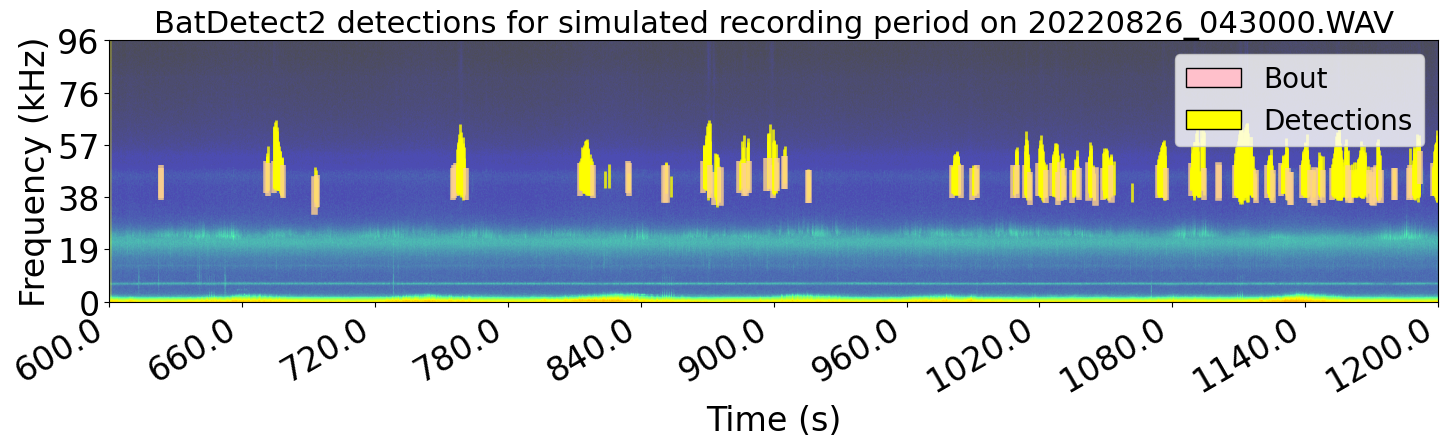

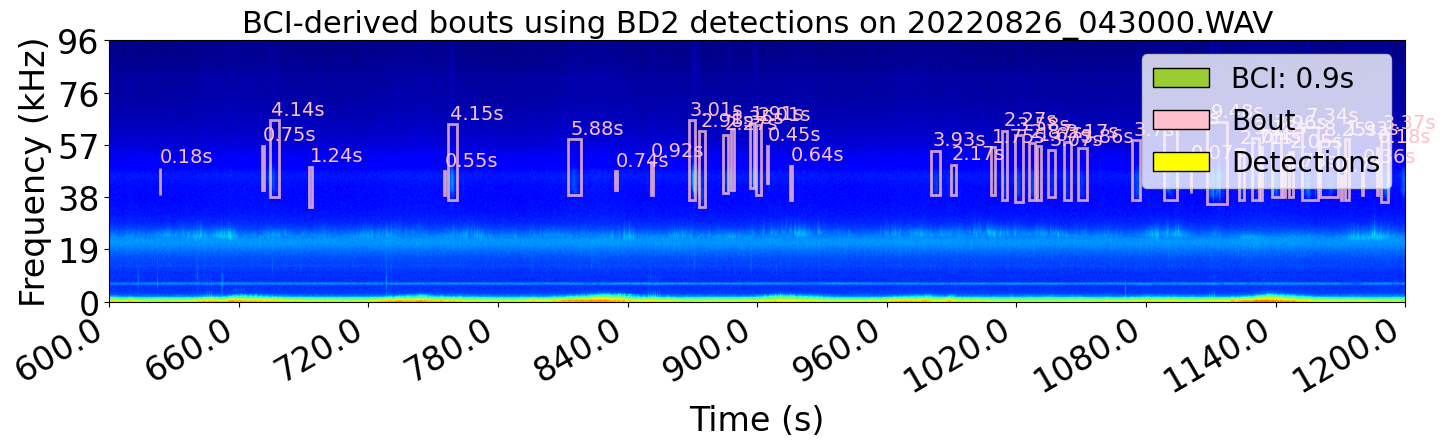

In [129]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [150]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 420
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

bout_params['bci'] = nlin_results['bci']

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

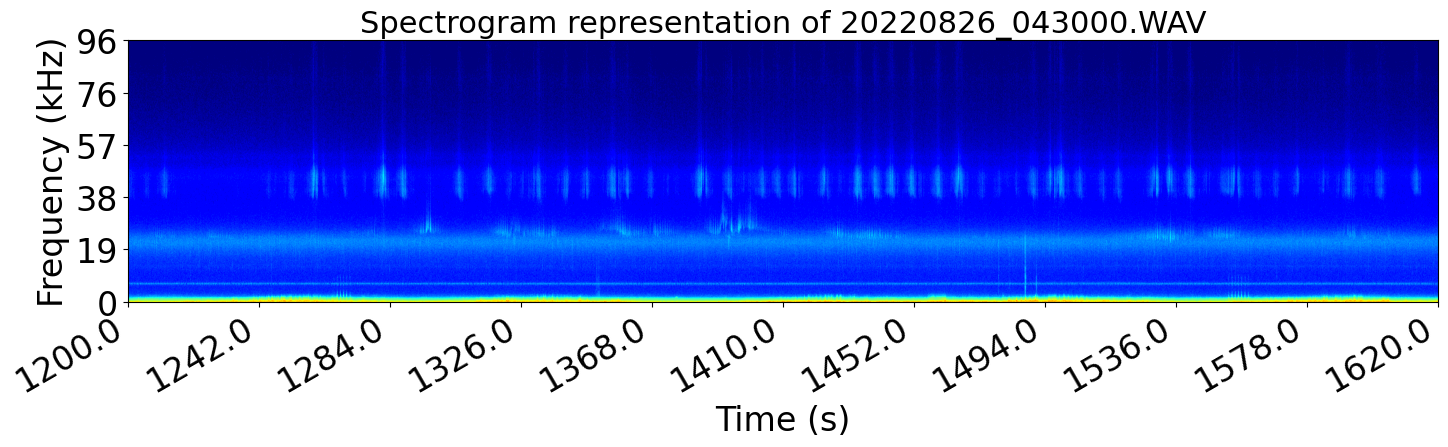

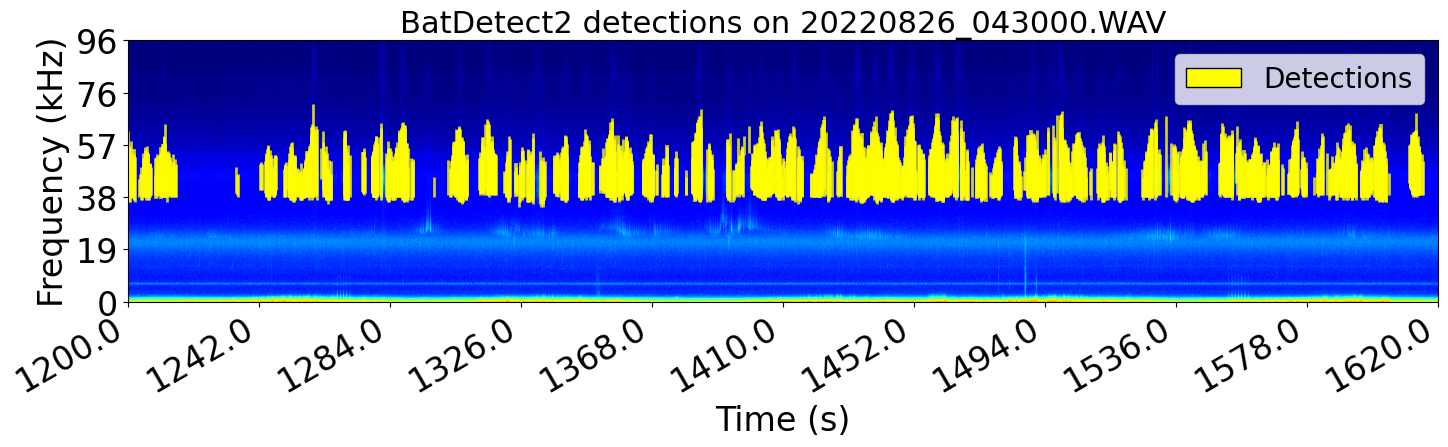

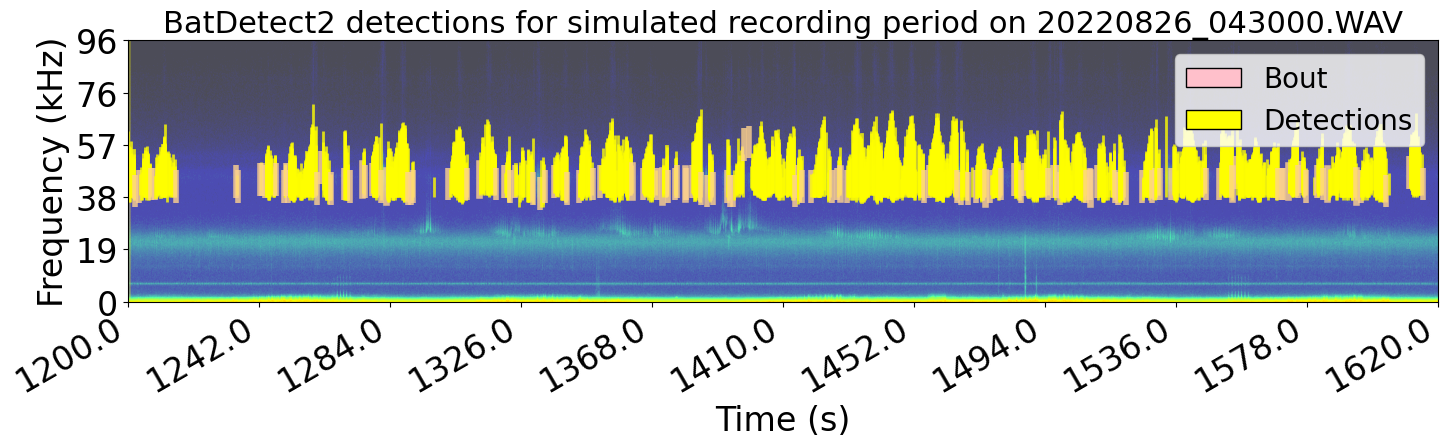

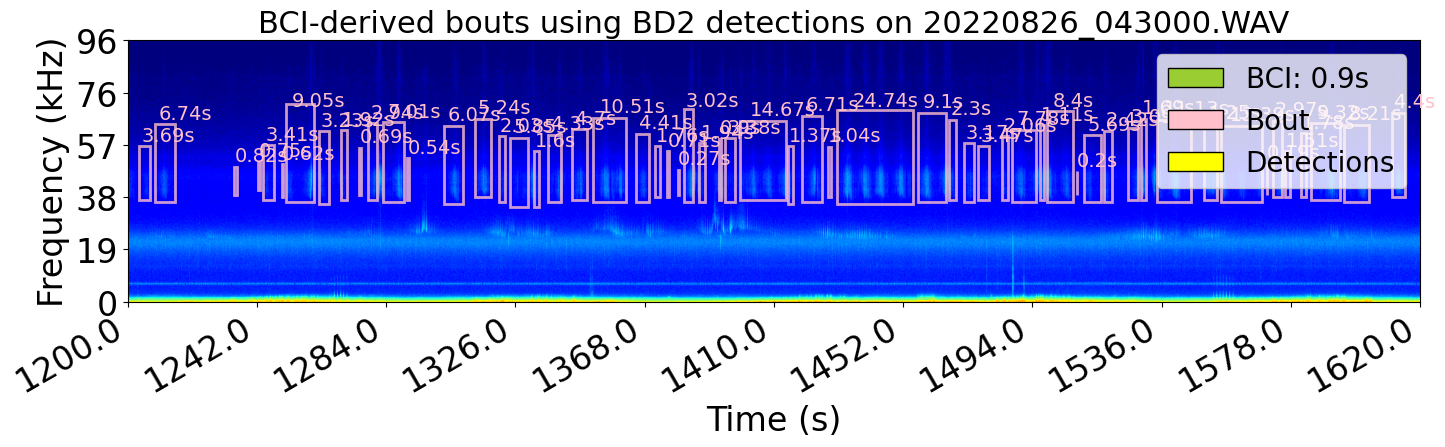

In [151]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [165]:
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_single_bd2_output(batdetect2_predictions, bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_classified_dets(batdetect2_preds_with_bouttags)
bout_metrics

start_time_of_bout              end_time_of_bout  start_time  \
0   2022-08-26 04:30:05.308500 2022-08-26 04:30:05.793400000      5.3085   
1   2022-08-26 04:30:10.154500 2022-08-26 04:30:10.764800000     10.1545   
2   2022-08-26 04:30:12.083500 2022-08-26 04:30:13.728800000     12.0835   
3   2022-08-26 04:30:52.116500 2022-08-26 04:30:53.911300000     52.1165   
4   2022-08-26 04:30:55.249500 2022-08-26 04:30:57.893200000     55.2495   
..                         ...                           ...         ...   
118 2022-08-26 04:56:35.247500 2022-08-26 04:56:43.457400000   1595.2475   
119 2022-08-26 04:56:50.743500 2022-08-26 04:56:55.143100000   1610.7435   
120 2022-08-26 04:57:29.792500 2022-08-26 04:57:31.299500000   1649.7925   
121 2022-08-26 04:57:32.833500 2022-08-26 04:57:34.031899999   1652.8335   
122 2022-08-26 04:58:52.718500 2022-08-26 04:58:53.421000000   1732.7185   

      end_time  low_freq  high_freq             bout_duration  \
0       5.7934   39218.0    48070.0    0 days 00:00:00.484900   
1      10.7648   40937.0    52093.0    0 days 00:00:00.610300   
2      13.7288   40937.0    53871.0    0 days 00:00:01.645300   
3      53.9113   42656.0    60841.0    0 days 00:00:01.794800   
4      57.8932   42656.0    74475.0    0 days 00:00:02.643700   
..         ...       ...        ...                       ...   
118  1603.4574   36640.0    65084.0    0 days 00:00:08.209900   
119  1615.1431   38359.0    69346.0    0 days 00:00:04.399600   
120  1651.2995   40937.0    51447.0    0 days 00:00:01.507000   
121  1654.0319   40937.0    58139.0 0 days 00:00:01.198399999   
122  1733.4210   43515.0    55874.0    0 days 00:00:00.702500   

     bout_duration_in_secs  
0                 0.484900  
1                 0.610300  
2                 1.645300  
3                 1.794800  
4                 2.643700  
..                     ...  
118               8.209900  
119               4.399600  
120               1.507000  
121               1.198399  
122               0.702500  

[123 rows x 8 columns]

In [166]:
bout_durations = bout_metrics['bout_duration_in_secs'].values
round(np.mean(bout_durations), 2), round(np.median(bout_durations), 2)

(3.32, 2.27)

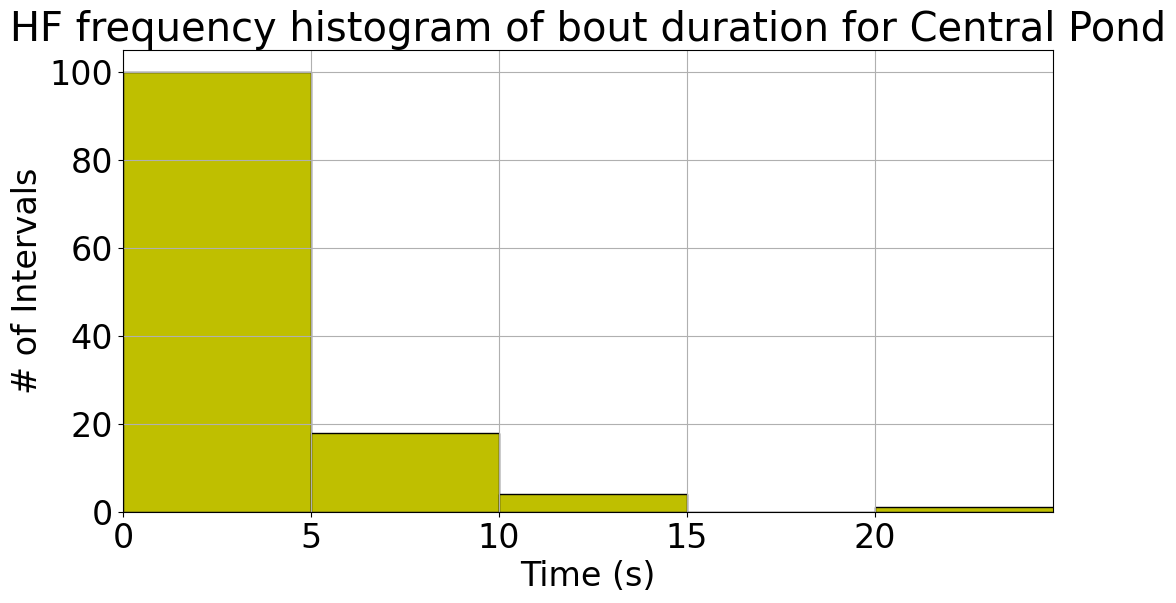

In [167]:
bout_durations = bout_metrics['bout_duration_in_secs'].values
plt.figure(figsize=(12, 6))
plt.title(f"{fig_details['freq_group']}frequency histogram of bout duration for {fig_details['site_name']}")
plt.hist(bout_durations, bins=np.arange(0, bout_durations.max()+1, 5), facecolor='y', edgecolor='k')
plt.xlim(0,  bout_durations.max())
plt.xlabel('Time (s)')
plt.grid(which='both')
plt.ylabel('# of Intervals')
plt.show()

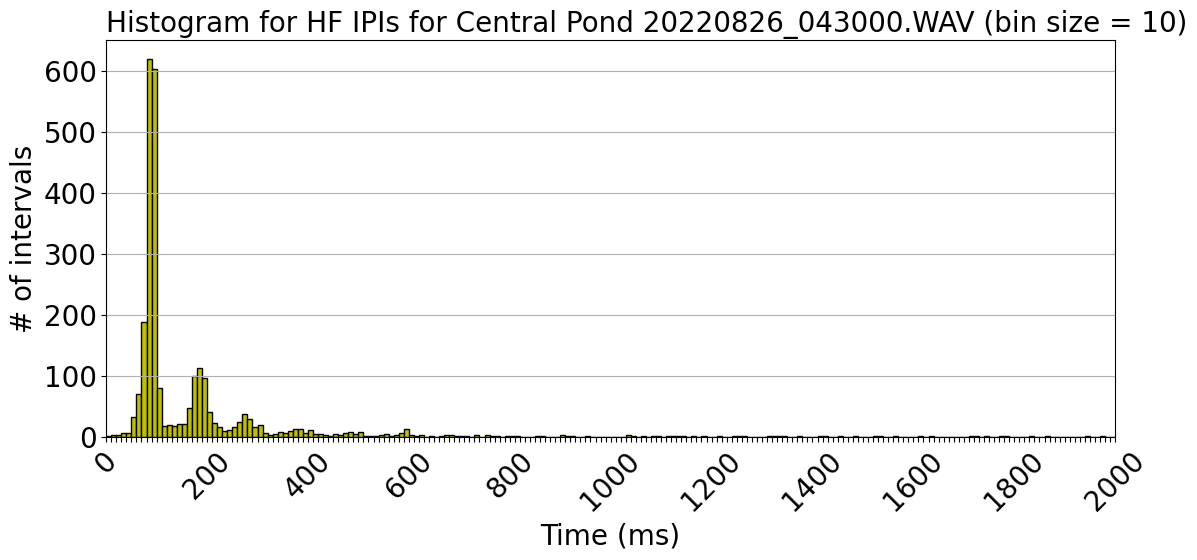

In [168]:
intervals = pd.to_datetime(batdetect2_predictions_no_dutycycle['call_start_time']) - pd.to_datetime(batdetect2_predictions_no_dutycycle['call_end_time']).shift(1)
batdetect2_predictions_no_dutycycle.insert(0, 'time_from_prev_call_end_time', intervals)
batdetect2_predictions_no_dutycycle = batdetect2_predictions_no_dutycycle.reset_index()
batdetect2_predictions_no_dutycycle.drop(columns=batdetect2_predictions_no_dutycycle.columns[0], inplace=True)

intervals = batdetect2_predictions_no_dutycycle['time_from_prev_call_end_time'].values
valid_intervals = intervals[~np.isnan(intervals)]
ipis_ms = valid_intervals.astype('float32')/1e6
assert((len(ipis_ms)+1) == len(batdetect2_predictions_no_dutycycle))

plt.rcParams.update({'font.size' : 20})
plt.figure(figsize=(12, 6))

fig_details['time_end'] = 2000

plt.title(f"Histogram for {fig_details['freq_group']}IPIs for {fig_details['site_name']} {file_path.name} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
plt.grid(axis='y')
bin_ticks = hist_bins.round(3)
bin_labels = [''] * len(bin_ticks)
bin_labels[::int(fig_details['time_end']/(10*fig_details['bin_step']))] = bin_ticks[::int(fig_details['time_end']/(10*fig_details['bin_step']))]

plt.xticks(bin_ticks, bin_labels, rotation=45)
plt.ylabel('# of intervals', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xlim(0, fig_details['time_end'])
plt.tight_layout()
plt.show()